In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

import pandas as pd
import numpy as np
import qiskit.pulse as pulse
from qiskit.circuit import Parameter
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit import schedule
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend

In [ ]:
#Set-Up:

In [3]:
backend = SingleTransmonTestBackend(5.2e9,-.25e9, 1e9, 0.8e9, noise=False, seed=100)
qubit = 0
cals=Calibrations.from_backend(backend)
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
Multi qubit instructions:
)>


In [4]:
# A function to instantiate calibrations and add a couple of template schedules.
def setup_cals(backend) -> Calibrations:

    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp, num_qubits=1)
    cals.add_schedule(xm, num_qubits=1)
    cals.add_schedule(x90p, num_qubits=1)

    return cals

# Add guesses for the parameter values to the calibrations.
def add_parameter_guesses(cals: Calibrations):

    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [5]:
cals = setup_cals(backend)
add_parameter_guesses(cals)
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(backend, libraries=[library])
print(library.default_values()) # check what parameter values this library has
print(cals.get_inst_map()) # check the new cals's InstructionScheduleMap made from the library
print(cals.get_schedule('x',(0,))) # check one of the schedules built from the new calibration

[DefaultCalValue(value=80.0, parameter='σ', qubits=(), schedule_name='x'), DefaultCalValue(value=0.0, parameter='β', qubits=(), schedule_name='x'), DefaultCalValue(value=320, parameter='duration', qubits=(), schedule_name='x'), DefaultCalValue(value=0.5, parameter='amp', qubits=(), schedule_name='x'), DefaultCalValue(value=0.0, parameter='β', qubits=(), schedule_name='sx'), DefaultCalValue(value=80.0, parameter='σ', qubits=(), schedule_name='sx'), DefaultCalValue(value=0.25, parameter='amp', qubits=(), schedule_name='sx'), DefaultCalValue(value=320, parameter='duration', qubits=(), schedule_name='sx')]
<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'sy', 'x', 'y'}
Multi qubit instructions:
)>
ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0, amp=0.5, angle=0), DriveChannel(0)), name="x", transform=AlignLeft())


In [6]:
from qiskit.pulse import InstructionScheduleMap
from qiskit_experiments.library import FineXAmplitude

In [7]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
d0, inst_map = pulse.DriveChannel(qubit), pulse.InstructionScheduleMap()

In [8]:
ideal_amp = x_pulse.amp
over_amp = ideal_amp*1.02
under_amp = ideal_amp*0.98
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f} which we set as ideal_amp.")
print(f"we use {over_amp:.4f} amplitude for overroation pulse and {under_amp:.4f} for underrotation pulse.")
# build the over rotated pulse and add it to the instruction schedule map
with pulse.build(backend=backend, name="x") as x_over:
    pulse.play(pulse.Drag(x_pulse.duration, over_amp, x_pulse.sigma, x_pulse.beta), d0)
inst_map.add("x", (qubit,), x_over)

The reported amplitude of the X pulse is 0.0582 which we set as ideal_amp.
we use 0.0594 amplitude for overroation pulse and 0.0570 for underrotation pulse.


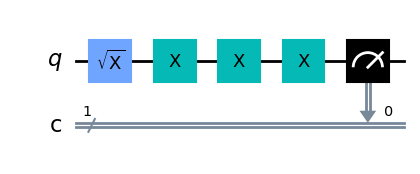

In [9]:
overamp_exp = FineXAmplitude(qubit, backend=backend)
overamp_exp.set_transpile_options(inst_map=inst_map)
overamp_exp.circuits()[4].draw(output='mpl')

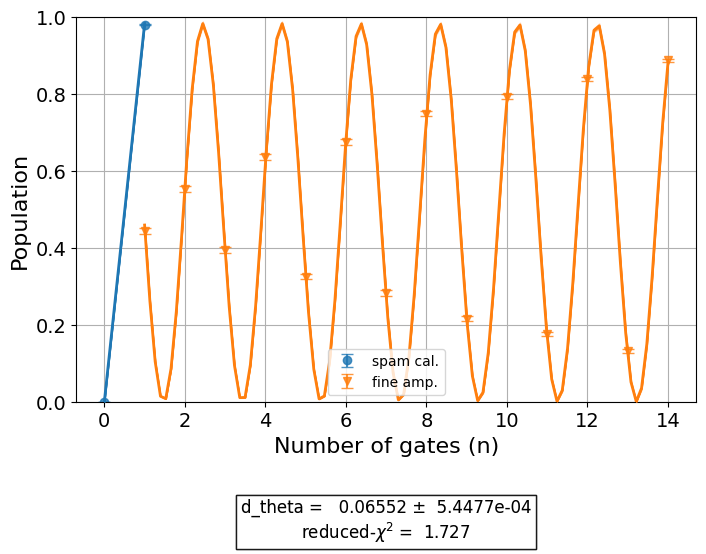

In [10]:
# do the experiment
exp_data_over = overamp_exp.run(backend).block_for_results()
exp_data_over.figure(0)

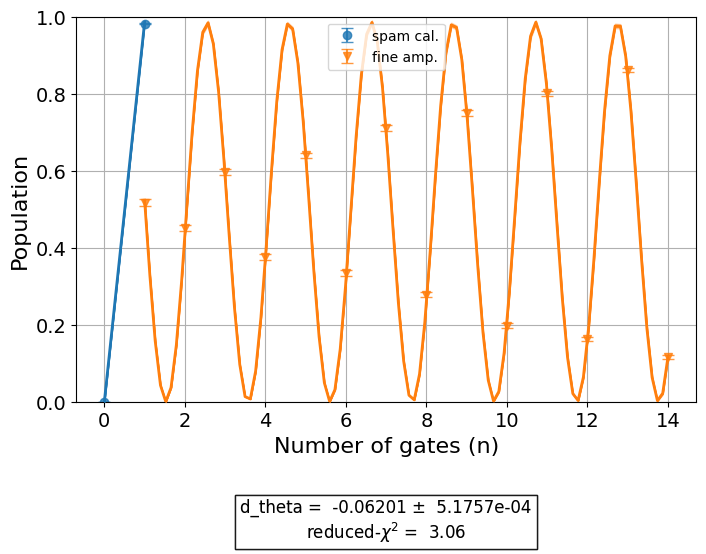

In [11]:
# build the under rotated pulse and add it to the instruction schedule map
with pulse.build(backend=backend, name="x") as x_under:
    pulse.play(pulse.Drag(x_pulse.duration, under_amp, x_pulse.sigma, x_pulse.beta), d0)
inst_map.add("x", (qubit,), x_under)

# do the experiment
underamp_exp = FineXAmplitude(qubit, backend=backend)
underamp_exp.set_transpile_options(inst_map=inst_map)

exp_data_under = underamp_exp.run(backend).block_for_results()
exp_data_under.figure(0)

In [12]:
# analyze the results
target_angle = np.pi
dtheta_over = exp_data_over.analysis_results("d_theta").value.nominal_value
scale_over = target_angle / (target_angle + dtheta_over)
dtheta_under = exp_data_under.analysis_results("d_theta").value.nominal_value
scale_under = target_angle / (target_angle + dtheta_under)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta_over:.3f} rad in over-rotated pulse case.")
print(f"Thus, scale the {over_amp:.4f} pulse amplitude by {scale_over:.3f} to obtain {over_amp*scale_over:.5f}.")
print(f"On the other hand, we measued a deviation of {dtheta_under:.3f} rad in under-rotated pulse case.")
print(f"Thus, scale the {under_amp:.4f} pulse amplitude by {scale_under:.3f} to obtain {under_amp*scale_under:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.066 rad in over-rotated pulse case.
Thus, scale the 0.0594 pulse amplitude by 0.980 to obtain 0.05817.
On the other hand, we measued a deviation of -0.062 rad in under-rotated pulse case.
Thus, scale the 0.0570 pulse amplitude by 1.020 to obtain 0.05820.
